# Demo of `uas_wq` functions and processing pipeline

In this notebook, we demonstrate the use functions included in UAS_WQ package

For each output, we show examples of saving data as a .csv, plotting spectra, and mapping individual images

pgedits - I'm not 100% sure the context of the line above this one ^ I think you should add a lot more details on what exactly is going on here.

In [3]:
# pgedits I thik all these imports and things should be tucked away in the .py script you make and then all 
# you'll need to do is import that one script

import os
from micasense import image as image
from micasense import imageset as imageset
from micasense import capture as capture
from micasense import image as image
from micasense import metadata as meta
from micasense import panel
import micasense.plotutils as plotutils

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import rasterio
import math

import warnings
warnings.filterwarnings('ignore')

# this is the location of the install of exiftool on the docker install I've created
exiftoolPath = '/usr/local/envs/micasense/bin/exiftool'

### Read in image directories (panel, sky, flight)

Please refer to the README.md to learn how to set up the directory for this code to function properly. 

This code block pulls in the three types of imagery needed for ocean color or water quality. The panel for calculation of Ed, the imagery of the sky (Lsky) to correct sky reflection, and the actual imagery of the water, also called Lt.

In [5]:
# pgedit
# I've made a few edits here to make this appropriate for the test data you provided and more generalizable with relative paths
# I'm not toally clear why you have a dirPath and an imagePath so I've deleted it, put it back if it was there for a reason!

# this path should point to your data directory
imagePath = os.path.join('data', 'test')

panel_imgset = imageset.ImageSet.from_directory(os.path.join(imagePath, 'panel'), exiftool_path=exiftoolPath).captures
print('# of panel captures =', len(panel_imgset))
sky_imgset = imageset.ImageSet.from_directory(os.path.join(imagePath, 'sky')).captures
print('# of Lsky captures =', len(sky_imgset))
flight_imgset = imageset.ImageSet.from_directory(os.path.join(imagePath, 'flight')).captures
print('# of flight captures =', len(flight_imgset))

Loading ImageSet from: data/test/panel
# of panel captures = 3
Loading ImageSet from: data/test/sky
# of Lsky captures = 2
Loading ImageSet from: data/test/flight
# of flight captures = 43


### 1) Store metadata (store_metadata)

Organize metadata from MicaSense GPS and IMU of flight captures. Metadata can be used for plotting flight capture locations and georeferencing

In [22]:
def store_metadata(imagePath):
    """
    <explain the functions purpose>

    Parameters
    ----------
    <parameter name> : <parameter format>
        <what is this parameter?>

    Returns
    -------
    <output_name> : <output format>
        <what is this output>
    --------
    """
    
    flight_imgset = imageset.ImageSet.from_directory(os.path.join(imagePath, 'flight')).captures
    
    columns = ['ID', 'SourceFile', 'DateTimeStamp','Latitude' ,'Longitude',
              'Altitude','Yaw', 'Pitch', 'Roll', 'SolarElevation']
    #,FocalLength_mm,ImageWidth,ImageHeight,ImageSize_?,Resolution_mm,SensorSize_mm\n"

    data=[]
    
    for i,capture in enumerate(flight_imgset):
        ID = 'capture_' + str(i+1)
        SourceFile =  os.path.join(imagePath, ID)
        DateTimeStamp = capture.utc_time().strftime("%Y:%m:%d,%H:%M:%S,")
        Latitude = capture.location()[0]
        Longitude = capture.location()[1]
        Altitude = capture.location()[2]
        Yaw = capture.images[0].dls_yaw
        Pitch = capture.images[0].dls_pitch
        Roll = capture.images[0].dls_roll
        SolarElevation = capture.images[0].solar_elevation
        
        # pgedits - why is this here below?
        '''
        #meta = metadata.Metadata(exiftoolPath=exiftoolPath)
        #print(meta.print_all())
        #print(meta.get_item('EXIF:FocalPlaneXResolution'))
        linestr += '"{}",'.format(capture.images[0].focal_length) #FocalLength_mm
        linestr += '"{}",'.format(meta.get_item('EXIF:ImageWidth')) #ImageWidth
        linestr += '"{}",'.format(meta.get_item('EXIF:ImageHeight')) #ImageHeight
        linestr += '"{}",'.format(capture.images[0].size()) #ImageSize_? #TODO- why is this diff than EXIF image width,height?
        linestr += '"{}",'.format(capture.images[0].focal_plane_resolution_px_per_mm) #Resolution_mm #TODO- this doesn't make sense
        linestr += '"{}",'.format(meta.get_item('EXIF:ImageWidth') / capture.images[0].focal_plane_resolution_px_per_mm[0], meta.get_item('EXIF:ImageHeight') / capture.images[0].focal_plane_resolution_px_per_mm[1]) #SensorSize
        # dividing the pixel size by the focal plane resolution in mm to get sensor size - px/(px/mm) leaves mm
        '''
        row = [ID] + [SourceFile] + [DateTimeStamp] + [Latitude] + [Longitude] + [Altitude] + \
        [Yaw] + [Pitch] + [Roll] + [SolarElevation]
        data.append(row)
        
        # pgedits making the time column datetime
        
        df = pd.DataFrame.from_records(data, index='ID', columns=columns)
        df['DateTimeStamp'] = pd.to_datetime(metadata.DateTimeStamp,format='%Y:%m:%d,%H:%M:%S,')
    
    return(df)

In [23]:
# pgedits I think once we have pulled out the actual function blocks we can just have blocks like this that explain the functions based on the documentation we add there inline.
?store_metadata

This functon creates a dataframe that can be used later. We can inspect a sample of what's included:

In [24]:
metadata = store_metadata(imagePath)
metadata.head(5)

Loading ImageSet from: data/test/flight


,SourceFile,DateTimeStamp,Latitude,Longitude,Altitude,Yaw,Pitch,Roll,SolarElevation
ID,,,,,,,,,
capture_1,data/test/capture_1,2020-10-01 16:01:41,38.696350,-75.979450,15.350,1.742016,0.133921,-0.073354,0.804977
capture_2,data/test/capture_2,2020-10-01 16:01:43,38.696348,-75.979458,20.059,1.751015,0.047817,-0.081847,0.805013
capture_3,data/test/capture_3,2020-10-01 16:01:45,38.696348,-75.979451,26.109,1.745869,0.175674,-0.079343,0.805050
capture_4,data/test/capture_4,2020-10-01 16:01:47,38.696347,-75.979478,31.630,1.761184,0.069222,-0.064344,0.805086
capture_5,data/test/capture_5,2020-10-01 16:01:49,38.696344,-75.979510,37.231,1.760881,0.041278,-0.071530,0.805122


### Save metadata as .csv and plot altitude & lat, lon

Text(0, 0.5, 'Latitude')

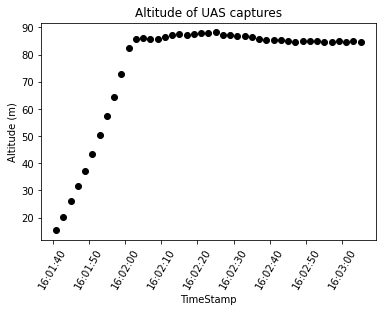

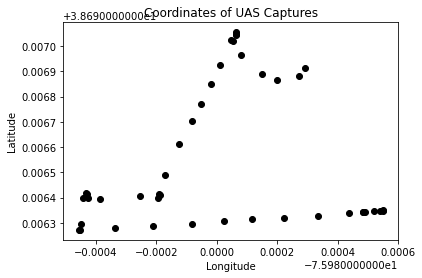

In [25]:
#Save metadata as .csv
metadata.to_csv(os.path.join(imagePath, 'metadata.csv'))
 
#plot altitude
plt.scatter(metadata['DateTimeStamp'].values, metadata['Altitude'].values, color='black')
plt.xticks(rotation=60)
plt.title("Altitude of UAS captures")
plt.xlabel("TimeStamp")
plt.ylabel("Altitude (m)")

#plot lat, lon
plt.figure(2)
plt.scatter(metadata['Longitude'].values, metadata['Latitude'].values, color='black')
plt.title("Coordinates of UAS Captures")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

### 2) Create aligned, stacked tifs of raw (DN) images (align_stack_flight_DN, align_stack_sky_DN)

This function applies an alignment procedure provided by MicaSense `create_aligned_capture()` that:

1) unwarps images using built-in lens calibration

2) applies transformation to align each band to a common band

3) crops pixels that don't overlap in all bands. 

It then stacks aligned bands into a single tiff using a stack export procedure `save_capture_as_stack()`. If the argument `generateThumbnails=True`, then RGB .jpg thumbnails will be created for reference. 

In [27]:
def align_stack_flight_DN(imagePath, generateThumbnails, overwrite, output_name):
    """
    <explain the functions purpose>

    Parameters
    ----------
    <parameter name> : <parameter format>
        <what is this parameter?>

    Returns
    -------
    <output_name> : <output format>
        <what is this output>
    ------
    """
    
    flight_imgset = imageset.ImageSet.from_directory(os.path.join(imagePath, 'flight')).captures
    
    #create new output directory paths
    flight_DN_outputPath = os.path.join(imagePath, output_name) #TODO- figure out how to get user to select file output path and name
    # pgedits for the above TODO, this doesn't need to be interactive, just have the output_name be an argument into the function
    flight_DN_thumbnailPath = os.path.join(imagePath, output_name+'_thumbnails')
    
     #create directories if they do not exist
    if not os.path.exists(flight_DN_outputPath):
        os.makedirs(flight_DN_outputPath)
    if generateThumbnails and not os.path.exists(flight_DN_thumbnailPath):
        os.makedirs(flight_DN_thumbnailPath)
    
    #Create aligned, stacked tifs of flight captures   
    for i,capture in enumerate(flight_imgset):
        flight_DN_outputFilename = 'flight_DN_' + str(i+1) +'.tif' #+1 so naming starts at 1, not 0
        flight_DN_thumbnailFilename = 'flight_DN_' + str(i+1) +'.jpg'
        if (not os.path.exists(os.path.join(flight_DN_outputPath, flight_DN_outputFilename))) or overwrite:
            align = capture.create_aligned_capture(irradiance_list=None, warp_matrices=None, img_type='radiance')
            stack = capture.save_capture_as_stack(os.path.join(flight_DN_outputPath, flight_DN_outputFilename), sort_by_wavelength = True)
            if generateThumbnails:
                capture.save_capture_as_rgb(os.path.join(flight_DN_thumbnailPath, flight_DN_thumbnailFilename))
    capture.clear_image_data()
    # pgedits, shouldn't this ^ clear_image_data() function be within the for loop not after it? You're only clearing the last capture not every one
    
    
    
#TODO- Figure out how to not make this as computational intensive- almost runs up my RAM with 43 images
# pgedits - it is also quite intensive on mine, but I don't know if that is really a problem, probably something for version 2.0 maybe not this initial one
    

In [28]:
align_stack_flight_DN(imagePath, generateThumbnails=True, overwrite=True, output_name='flight_DN_stacks')

Loading ImageSet from: data/test/flight


In [9]:
def align_stack_sky_DN(imagePath, generateThumbnails, overwrite, output_name):
    """
    <explain the functions purpose>

    Parameters
    ----------
    <parameter name> : <parameter format>
        <what is this parameter?>

    Returns
    -------
    <output_name> : <output format>
        <what is this output>
    ------
    """
    
    sky_imgset = imageset.ImageSet.from_directory(os.path.join(imagePath, 'sky')).captures
    
    #create new output directory paths
    sky_DN_outputPath = os.path.join(imagePath, output_name)
    sky_DN_thumbnailPath = os.path.join(imagePath, output_name+'_thumbnails')
    
     #create directories if they do not exist
    if not os.path.exists(sky_DN_outputPath):
        os.makedirs(sky_DN_outputPath)
    if generateThumbnails and not os.path.exists(sky_DN_thumbnailPath):
        os.makedirs(sky_DN_thumbnailPath)
    
    #Create aligned, stacked tifs of flight captures   
    for i,capture in enumerate(sky_imgset):
        sky_DN_outputFilename = 'sky_DN_' + str(i+1) +'.tif' #+1 so naming starts at 1, not 0
        sky_DN_thumbnailFilename = 'sky_DN_' + str(i+1) +'.jpg'
        if (not os.path.exists(os.path.join(sky_DN_outputPath, sky_DN_outputFilename))) or overwrite:
            align = capture.create_aligned_capture(irradiance_list=None, warp_matrices=None, img_type='radiance')
            stack = capture.save_capture_as_stack(os.path.join(sky_DN_outputPath, sky_DN_outputFilename), sort_by_wavelength = True)
            if generateThumbnails:
                capture.save_capture_as_rgb(os.path.join(sky_DN_thumbnailPath, sky_DN_thumbnailFilename))
    capture.clear_image_data()

In [11]:
align_stack_sky_DN(imagePath, generateThumbnails=True, overwrite=True, output_name='sky_DN_stacks')

Loading ImageSet from: data/test/sky


### 3) Radiance (align_stack_Lt, align_stack_Lsky)
#### This function applies a radiometric calibration procedure provided by MicaSense (create_aligned_capture) to convert DN values to radiance values with units of mW m<sup>-2</sup> nm<sup>-1</sup> sr<sup>-1</sup> and exports them as single tifs. 

In [15]:
def align_stack_Lt(imagePath, overwrite, output_name):
    """
    <explain the functions purpose>

    Parameters
    ----------
    <parameter name> : <parameter format>
        <what is this parameter?>

    Returns
    -------
    <output_name> : <output format>
        <what is this output>
    ------
    """
    
    flight_imgset = imageset.ImageSet.from_directory(os.path.join(imagePath, 'flight')).captures

    #create new output directory paths
    Lt_outputPath = os.path.join(imagePath, output_name)
    
    #create directories if they do not exist
    if not os.path.exists(Lt_outputPath):
        os.makedirs(Lt_outputPath)
   
    #Create aligned, stacked tifs of Lt captures   
    for i,capture in enumerate(flight_imgset):
        Lt_outputFilename = 'Lt_' + str(i+1) +'.tif' #+1 so naming starts at 1, not 0
        if (not os.path.exists(os.path.join(Lt_outputPath, Lt_outputFilename))) or overwrite:
            align = capture.create_aligned_capture(irradiance_list=None, warp_matrices=None, img_type='radiance')
            align = align * 1000 #scale to mW
            align = np.moveaxis(align, -1, -0) #change order of dimensions 
            align[[[3,4]],:,:] = align[[[4,3]],:,:] #flip last two bands (RedEdge and NIR)
            
            # open original flight_DN stacked tif
            with rasterio.open(os.path.join(imagePath, 'flight_DN_stacks', 'flight_DN_'+str(i+1)+'.tif'), 'r') as src:
                profile = src.profile

                profile.update(dtype=rasterio.float32) #change from unit16 to float32 ??
                
                #write new stacked Lt tif w/ radiance units
                with rasterio.open(os.path.join(Lt_outputPath, Lt_outputFilename), 'w', **profile) as dst:
                    dst.write(align)

            capture.clear_image_data()

In [16]:
align_stack_Lt(imagePath, overwrite=True, output_name = 'Lt_stacks')

Loading ImageSet from: data/test/flight


In [17]:
def align_stack_Lsky(imagePath, overwrite, output_name):
    """
    <explain the functions purpose>

    Parameters
    ----------
    <parameter name> : <parameter format>
        <what is this parameter?>

    Returns
    -------
    <output_name> : <output format>
        <what is this output>
    ------
    """
    
    sky_imgset = imageset.ImageSet.from_directory(os.path.join(imagePath, 'sky')).captures

    #create new output directory paths
    Lsky_outputPath = os.path.join(imagePath, output_name)
    
    #create directories if they do not exist
    if not os.path.exists(Lsky_outputPath):
        os.makedirs(Lsky_outputPath)
   
    #Create aligned, stacked tifs of Lsky captures   
    for i,capture in enumerate(sky_imgset):
        Lsky_outputFilename = 'Lsky_' + str(i+1) +'.tif' #+1 so naming starts at 1, not 0
        if (not os.path.exists(os.path.join(Lsky_outputPath, Lsky_outputFilename))) or overwrite:
            align = capture.create_aligned_capture(irradiance_list=None, warp_matrices=None, img_type='radiance')
            align = align * 1000 #scale to mW
            align = np.moveaxis(align, -1, -0) #change order of dimensions 
            align[[[3,4]],:,:] = align[[[4,3]],:,:] #flip last two bands (RedEdge and NIR)

            # open original flight_DN stacked tif
            with rasterio.open(os.path.join(imagePath, 'sky_DN_stacks', 'sky_DN_'+str(i+1)+'.tif'), 'r') as src:
                profile = src.profile

                profile.update(dtype=rasterio.float32) #change from unit16 to float32 ??
                
                #write new stacked Lt tif w/ radiance units
                with rasterio.open(os.path.join(Lsky_outputPath, Lsky_outputFilename), 'w', **profile) as dst:
                    dst.write(align)

            capture.clear_image_data()

In [18]:
align_stack_Lsky(imagePath, overwrite=True, output_name='Lsky_stacks')

Loading ImageSet from: data/test/sky


### Save mean L<sub>t</sub> data as .csv

In [31]:
#open all Lt_stacks tifs and create table of mean Lt across bands
Lt_data = []
columns = ['image', 'Lt_475', 'Lt_560', 'Lt_668', 'Lt_717', 'Lt_842']

for im in glob.glob(os.path.join(imagePath,'Lt_stacks')+ "/*.tif"):
    with rasterio.open(im, 'r') as src:
        Lt = src.read() 
        # pgedits - it is a little strange to overwrite an image with a list, I would use a different variable
        # even though they'll all be overwritten anyway in the for loop
        Lt = ['capture_'+str(im)]+[np.mean(Lt[0,:,:])]+[np.mean(Lt[1,:,:])]+[np.mean(Lt[2,:,:])]+[np.mean(Lt[3,:,:])]+[np.mean(Lt[4,:,:])]
        Lt_data.append(Lt)

#save mean Lt data for each image as .csv
# pgedits - we probably want the timestamp along with all of these images included in the dataframe
Lt_data = pd.DataFrame.from_records(Lt_data, index='image', columns = columns)
Lt_data.to_csv(os.path.join(imagePath, 'Lt_data.csv'))
print(Lt_data.head())

                                          Lt_475     Lt_560     Lt_668  \
image                                                                    
capture_data/test/Lt_stacks/Lt_1.tif   11.041909  16.182291  15.779916   
capture_data/test/Lt_stacks/Lt_10.tif   6.165128  10.519750  10.400275   
capture_data/test/Lt_stacks/Lt_11.tif   6.095629  10.385229  10.241643   
capture_data/test/Lt_stacks/Lt_12.tif   6.270853  10.622685  10.475711   
capture_data/test/Lt_stacks/Lt_13.tif   6.216158  10.552398  10.387522   

                                          Lt_717    Lt_842  
image                                                       
capture_data/test/Lt_stacks/Lt_1.tif   12.464837  5.859059  
capture_data/test/Lt_stacks/Lt_10.tif   7.900624  2.912021  
capture_data/test/Lt_stacks/Lt_11.tif   7.748768  2.817319  
capture_data/test/Lt_stacks/Lt_12.tif   7.937401  2.977577  
capture_data/test/Lt_stacks/Lt_13.tif   7.857113  2.924747  


### plot L<sub>t</sub> spectra for each flight capture

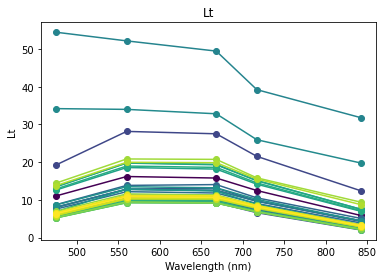

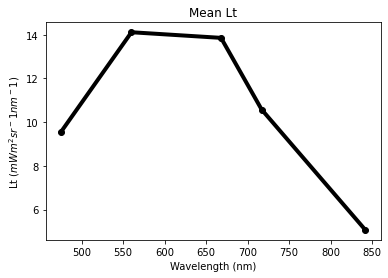

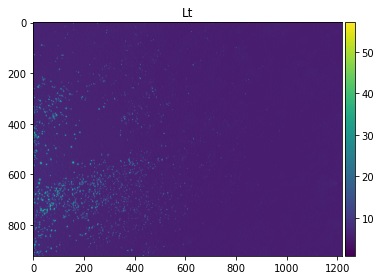

In [32]:
#plot Lt for every capture
colors = plt.cm.viridis(np.linspace(0,1,len(Lt_data)))
wv = [475, 560, 668, 717, 842]
for i in range(len(Lt_data)):
    plt.plot(wv, Lt_data.iloc[i,0:5],  marker = 'o', color=colors[i])
    plt.title('Lt')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Lt') #TODO- add units

#plot mean Lt across all images 
plt.figure(2)
plt.plot(wv, np.mean(Lt_data.iloc[:,0:5]),  marker = 'o', color='black', linewidth=4)
plt.title('Mean Lt')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Lt ($mW m^2 sr^-1 nm^-1$)')


#Plot example Lt .tiff
with rasterio.open(os.path.join(imagePath,'Lt_stacks','Lt_11.tif'), 'r') as src:
    Lt = src.read() 
    fig, axis = plotutils.plotwithcolorbar(Lt[0,:,:], title='Lt') #5th image


#### Save mean L<sub>sky</sub> data as .csv and plot L<sub>sky</sub> spectra for each sky capture

                                           Lsky_475   Lsky_560   Lsky_668  \
image                                                                       
capture_data/test/Lsky_stacks/Lsky_1.tif  35.252716  19.730360   8.901214   
capture_data/test/Lsky_stacks/Lsky_2.tif  53.910156  34.435318  15.727980   

                                           Lsky_717  Lsky_842  
image                                                          
capture_data/test/Lsky_stacks/Lsky_1.tif   6.422426  3.696146  
capture_data/test/Lsky_stacks/Lsky_2.tif  10.083089  5.997991  


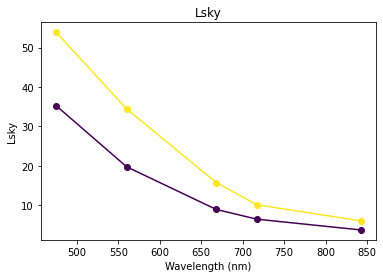

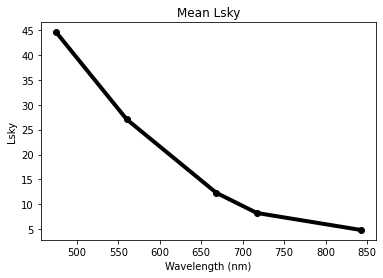

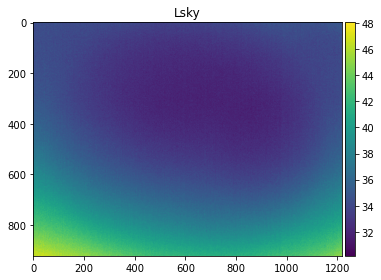

In [33]:
# pgedits - where feasible you never really want repeated code, this could all be in a for loop with the above code,
# you're declaring all the same variables and running the same process.

#open all Lsky_stacks tifs and create table of mean Lsky across bands
Lsky_data = []
columns = ['image', 'Lsky_475', 'Lsky_560', 'Lsky_668', 'Lsky_717', 'Lsky_842']
for im in glob.glob(os.path.join(imagePath,'Lsky_stacks')+ "/*.tif"):
    with rasterio.open(im, 'r') as src:
        Lsky = src.read() 
        Lsky = ['capture_'+str(im)]+[np.mean(Lsky[0,:,:])]+[np.mean(Lsky[1,:,:])]+[np.mean(Lsky[2,:,:])]+[np.mean(Lsky[3,:,:])]+[np.mean(Lsky[4,:,:])]
        Lsky_data.append(Lsky)

#save mean Lsky data for each image as .csv
Lsky_data = pd.DataFrame.from_records(Lsky_data, index='image', columns = columns)
Lsky_data.to_csv(os.path.join(imagePath, 'Lsky_data.csv'))
print(Lsky_data.head())

#plot Lsky for every capture
colors = plt.cm.viridis(np.linspace(0,1,len(Lsky_data)))
wv = [475, 560, 668, 717, 842]
for i in range(len(Lsky_data)):
    plt.plot(wv, Lsky_data.iloc[i,0:5],  marker = 'o', color=colors[i])
    plt.title('Lsky')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Lsky') #TODO- add units

#plot mean Lsky across all images 
plt.figure(2)
plt.plot(wv, np.mean(Lsky_data.iloc[:,0:5]),  marker = 'o', color='black', linewidth=4)
plt.title('Mean Lsky')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Lsky') #TODO - add units

#Plot example Lsky .tiff
with rasterio.open(os.path.join(imagePath,'Lsky_stacks','Lsky_1.tif'), 'r') as src:
    Lsky = src.read() 
    fig, axis = plotutils.plotwithcolorbar(Lsky[0,:,:], title='Lsky') #5th image


### 4) Reflectance (R<sub>UAS</sub>) 

This function calculates total reflectance (here termed R<sub>UAS</sub>, also often called irradiance reflectance or just R) by dividing downwelling irradiance (E<sub>d</sub>) from total radiance (L<sub>t</sub>). 

Ed can be obtained three different ways:

1) 'DLS' : Ed is collected from the downwelling light sensor (DLS) with no correction

2) 'panel': Ed is calcualted from an image of the calibration reflectance panel

3) 'DLS_corr': DLS Ed is corrected using an image of the calibration reflectance panel 

pgedits - this should really be a function that takes in in an Ed argument (DLS, panel, or DLS_corr), and then runs the same code but branches depending on which option was chosen.

#### 1) DLS: save as .csv and plot for each flight capture

Loading ImageSet from: data/test/flight
                Ed_475       Ed_560      Ed_668      Ed_717      Ed_842
image                                                                  
capture_1  1284.275977  1125.494856  946.918420  758.215873  595.114984
capture_2  1280.456625  1122.085552  944.144570  755.989985  593.425974
capture_3  1268.157745  1110.597166  932.991454  747.811209  586.741503
capture_4  1264.482970  1106.195391  929.197540  745.051533  584.241646
capture_5  1261.944147  1104.465548  927.889727  743.907972  583.501033


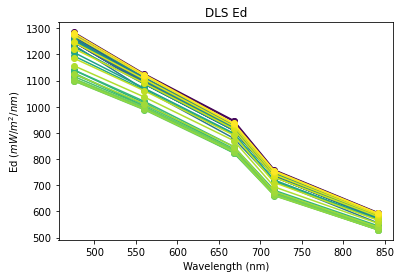

In [21]:
flight_imgset = imageset.ImageSet.from_directory(os.path.join(imagePath, 'flight')).captures

DLS_Ed_data = []
Ed_columns = ['image', 'Ed_475', 'Ed_560', 'Ed_668', 'Ed_717', 'Ed_842']
for i,capture in enumerate(flight_imgset):
        DLS_Ed = capture.dls_irradiance()
        DLS_Ed[3], DLS_Ed[4] = DLS_Ed[4], DLS_Ed[3] #flip last two bands (red edge and NIR)
        DLS_Ed = np.array(DLS_Ed)*1000 #Scale to mW
        DLS_Ed_row = ['capture_'+str(i+1)]+[np.mean(DLS_Ed[0])]+[np.mean(DLS_Ed[1])]+[np.mean(DLS_Ed[2])]+[np.mean(DLS_Ed[3])]+[np.mean(DLS_Ed[4])]
        DLS_Ed_data.append(DLS_Ed_row)
        
#save mean DLS Ed data for each image as .csv
DLS_Ed_data = pd.DataFrame.from_records(DLS_Ed_data, index='image', columns = Ed_columns)
DLS_Ed_data.to_csv(os.path.join(imagePath, 'DLS_Ed_data.csv'))
print(DLS_Ed_data.head())

#plot Ed for every capture
colors = plt.cm.viridis(np.linspace(0,1,len(DLS_Ed_data)))
wv = [475, 560, 668, 717, 842]
for i in range(len(DLS_Ed_data)):
    plt.plot(wv, DLS_Ed_data.iloc[i,0:5],  marker = 'o', color=colors[i])
    plt.title('DLS Ed')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Ed ($mW/m^2/nm$)') 

#### 2) Panel: save as .csv and plot for each panel capture

Loading ImageSet from: data/test/panel
              Ed_475       Ed_560      Ed_668      Ed_717      Ed_842
image                                                                
panel_1  1028.429051  1077.344372  925.620038  772.794358  622.374741
panel_2  1032.521777  1078.452768  927.435254  773.861176  623.405408
panel_3  1024.083706  1068.281762  914.790854  763.043653  616.291225


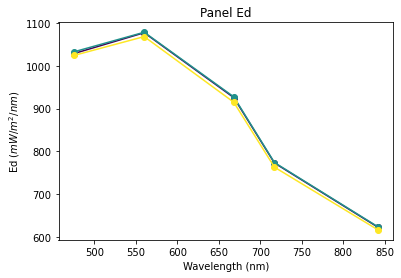

In [22]:
panel_imgset = imageset.ImageSet.from_directory(os.path.join(imagePath, 'panel')).captures
panels = np.array(panel_imgset)
                     
panel_Ed_data = []
Ed_columns = ['image', 'Ed_475', 'Ed_560', 'Ed_668', 'Ed_717', 'Ed_842']
for i in range(len(panels)):
                                
    #calculate panel Ed from every panel capture
    panel_Ed = np.array(panels[i].panel_irradiance())*1000 #scale to mW
    panel_Ed[3], panel_Ed[4] = panel_Ed[4], panel_Ed[3] #flip last two bands
    panel_Ed_row = ['panel_'+str(i+1)]+[np.mean(panel_Ed[0])]+[np.mean(panel_Ed[1])]+[np.mean(panel_Ed[2])]+[np.mean(panel_Ed[3])]+[np.mean(panel_Ed[4])]
    panel_Ed_data.append(panel_Ed_row)

#save mean panel Ed data for each image as .csv
panel_Ed_data = pd.DataFrame.from_records(panel_Ed_data, index='image', columns = Ed_columns)
panel_Ed_data.to_csv(os.path.join(imagePath, 'panel_Ed_data.csv'))
print(panel_Ed_data.head())

#plot panel Ed for every panel capture
colors = plt.cm.viridis(np.linspace(0,1,len(panel_Ed_data)))
wv = [475, 560, 668, 717, 842]
for i in range(len(panel_Ed_data)):
    plt.plot(wv, panel_Ed_data.iloc[i,0:5],  marker = 'o', color=colors[i])
    plt.title('Panel Ed')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Ed ($mW/m^2/nm$)') 

#### 3: DLS_corr: save as .csv and plot for each flight capture

[0.5215, 0.5220666666666667, 0.5227866666666666, 0.5239466666666667, 0.5231133333333333]
Loading ImageSet from: data/test/panel
                Ed_475       Ed_560      Ed_668      Ed_717      Ed_842
image                                                                  
capture_1  1028.344845  1074.692967  922.615382  768.675209  621.679234
capture_2  1028.344845  1074.692967  922.615382  768.675209  621.679234
capture_3  1028.344845  1074.692967  922.615382  768.675209  621.679234
capture_4  1028.344845  1074.692967  922.615382  768.675209  621.679234
capture_5  1028.344845  1074.692967  922.615382  768.675209  621.679234


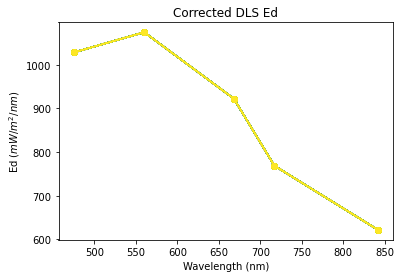

In [23]:
#get reflectance from panel serial #
panel_reflectance_from_serial = []
for i in range(5):
    foo = panel.Panel(image.Image(os.path.join(imagePath,'panel', 'IMG_0001_'+ str(i+1) + '.tif'))). reflectance_from_panel_serial()
    panel_reflectance_from_serial.append(foo)
print(panel_reflectance_from_serial)

#get mean radiance from panel
panel_imgset = imageset.ImageSet.from_directory(os.path.join(imagePath, 'panel')).captures
panels = np.array(panel_imgset)

panel_radiances = []
for cap in panels:
    if cap.panels_in_all_expected_images():
        panel_radiances.append(cap.panel_radiance())
panel_radiances = np.mean(np.asarray(panel_radiances)*1000, axis=0)
panel_radiances[3], panel_radiances[4] = panel_radiances[4], panel_radiances[3] #flip last two bands

#get mean irradiance from panel using known panel reflectance (from serial)
irr_from_panel = math.pi * panel_radiances / panel_reflectance_from_serial

#calculate DLS correction = irr from panel / DLS irradiances
corrected_DLS_Ed_data = []
Ed_columns = ['image', 'Ed_475', 'Ed_560', 'Ed_668', 'Ed_717', 'Ed_842']
for i,capture in enumerate(flight_imgset):
    DLS_Ed = capture.dls_irradiance()
    DLS_Ed[3], DLS_Ed[4] = DLS_Ed[4], DLS_Ed[3] #flip last two bands (red edge and NIR)
    DLS_Ed = np.array(DLS_Ed)*1000 #Scale to mW
    dls_correction = irr_from_panel/DLS_Ed
    corrected_DLS = DLS_Ed*dls_correction
    corrected_DLS_row = ['capture_'+str(i+1)]+[corrected_DLS[0]]+[corrected_DLS[1]]+[corrected_DLS[2]]+[corrected_DLS[3]]+[corrected_DLS[4]]
    corrected_DLS_Ed_data.append(corrected_DLS_row)

#save mean panel Ed data for each image as .csv
corrected_DLS_Ed_data = pd.DataFrame.from_records(corrected_DLS_Ed_data, index='image', columns = Ed_columns)
corrected_DLS_Ed_data.to_csv(os.path.join(imagePath, 'corrected_DLS_Ed_data.csv'))
print(corrected_DLS_Ed_data.head())

#plot panel Ed for every panel capture
colors = plt.cm.viridis(np.linspace(0,1,len(corrected_DLS_Ed_data)))
wv = [475, 560, 668, 717, 842]
for i in range(len(corrected_DLS_Ed_data)):
    plt.plot(wv, corrected_DLS_Ed_data.iloc[i,0:5],  marker = 'o', color=colors[i])
    plt.title('Corrected DLS Ed')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Ed ($mW/m^2/nm$)') 


### Ruas

Convert raw (DN) individual images to aliged, stacked tiffs with units of reflectance (Ruas = Lt/Ed)

Ed_opt =

1: use DLS Ed

2: use panel Ed

3: use DLS Ed with a correction

In [106]:
def align_stack_Ruas(imagePath, overwrite, Ed_opt, panel_ref_from_serial, output_name):
    """
    <explain the functions purpose>

    Parameters
    ----------
    <parameter name> : <parameter format>
        <what is this parameter?>

    Returns
    -------
    <output_name> : <output format>
        <what is this output>
    ------
    """
    
    flight_imgset = imageset.ImageSet.from_directory(os.path.join(imagePath, 'flight')).captures
    panel_imgset = imageset.ImageSet.from_directory(os.path.join(imagePath, 'panel')).captures

    #create new output directory paths
    Ruas_outputPath = os.path.join(imagePath, output_name)
    
    #create directories if they do not exist
    if not os.path.exists(Ruas_outputPath):
        os.makedirs(Ruas_outputPath)
  
    #Get Ed from flight captures
    for i,capture in enumerate(flight_imgset):
        Ruas_outputFilename = 'Ruas_' + str(i+1) +'.tif'
        if (not os.path.exists(os.path.join(Ruas_outputPath, Ruas_outputFilename))) or overwrite:
            
            #Get DLS Ed
            if Ed_opt == 'DLS':
                Ed = capture.dls_irradiance()
                Ed[3], Ed[4] = Ed[4], Ed[3] #flip last two bands (red edge and NIR)
                Ed = np.array(Ed)*1000 #Scale to mW
            
            #Get panel Ed
            if Ed_opt == 'panel':
                panels = np.array(panel_imgset)                
                for i in range(len(panels)):         
                    #calculate panel Ed from every panel capture
                    Ed = np.array(panels[i].panel_irradiance())*1000 #scale to mW
                    Ed[3], Ed[4] = Ed[4], Ed[3] #flip last two bands
            
            #Calculate DLS Ed with a correction from calibration reflectance panel
            if Ed_opt == 'DLS_corr':
                panels = np.array(panel_imgset)
                panel_radiances = []
                for cap in panels:
                    if cap.panels_in_all_expected_images():
                        panel_radiances.append(cap.panel_radiance())
                panel_radiances = np.mean(np.asarray(panel_radiances)*1000, axis=0)
                panel_radiances[3], panel_radiances[4] = panel_radiances[4], panel_radiances[3] #flip last two bands
                
                #get mean irradiance from panel using known panel reflectance (from serial)
                irr_from_panel = math.pi * panel_radiances / panel_ref_from_serial
                
                #calculate DLS correction = irr from panel / DLS irradiances
                dls_correction = irr_from_panel/capture.dls_irradiance()
                Ed = capture.dls_irradiance()*dls_correction
                
        
        #write new tifs with Ruas values
        with rasterio.open(os.path.join(imagePath, 'Lt_stacks', 'Lt_'+str(i+1)+'.tif')) as src:
            profile = src.profile

            Ruas_all = []
            for j in range(1,6):
                #calculate Ruas (Lt/Ed)
                Ruas = src.read(j)/Ed[j-1] #for every band in Lt stack, divide by Ed band
                Ruas_all.append(Ruas) #append all Ruas for each band
            stacked_Ruas = np.stack(Ruas_all) #stack into np.array
            
            #write new stacked Ruas tif w/ reflectance units
            with rasterio.open(os.path.join(Ruas_outputPath, Ruas_outputFilename), 'w', **profile) as dst:
                dst.write(stacked_Ruas)
        
        capture.clear_image_data()

In [107]:
align_stack_Ruas(imagePath, overwrite=True, Ed_opt='DLS_corr', panel_ref_from_serial=panel_reflectance_from_serial, output_name='Ruas_stacks')

##### Save mean Ruas data as csv and plot spectra

                                                    Ruas_475  Ruas_560  \
image                                                                    
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.010737  0.015057   
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.005995  0.009788   
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.005927  0.009663   
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.006097  0.009884   
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.006044  0.009819   

                                                    Ruas_668  Ruas_717  \
image                                                                    
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.017102  0.016215   
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.011272  0.010277   
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.011100  0.010080   
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.011353  0.010326   
capture_F:/Micasense_WQ\10_01_20\0002

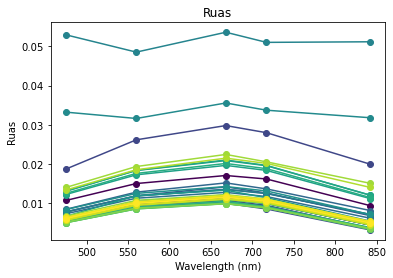

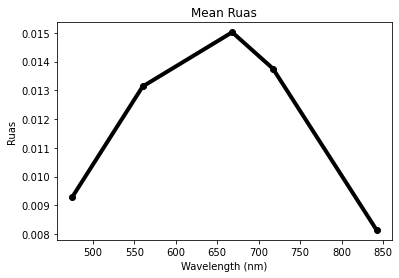

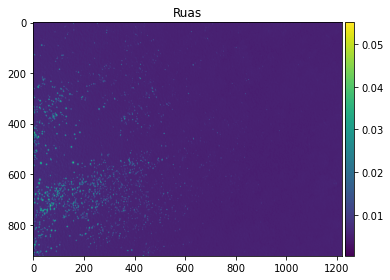

In [108]:
#open all Ruas_stacks tifs and create table of mean Ruas across bands
Ruas_data = []
columns = ['image', 'Ruas_475', 'Ruas_560', 'Ruas_668', 'Ruas_717', 'Ruas_842']
for im in glob.glob(os.path.join(imagePath,'Ruas_stacks')+ "/*.tif"):
    with rasterio.open(im, 'r') as src:
        Ruas = src.read() 
        Ruas = ['capture_'+str(im)]+[np.mean(Ruas[0,:,:])]+[np.mean(Ruas[1,:,:])]+[np.mean(Ruas[2,:,:])]+[np.mean(Ruas[3,:,:])]+[np.mean(Ruas[4,:,:])]
        Ruas_data.append(Ruas)

#save mean Ruas data for each image as .csv
Ruas_data = pd.DataFrame.from_records(Ruas_data, index='image', columns = columns)
Ruas_data.to_csv(os.path.join(imagePath, 'Ruas_data.csv'))
print(Ruas_data.head())

#plot Ruas for every capture
colors = plt.cm.viridis(np.linspace(0,1,len(Ruas_data)))
wv = [475, 560, 668, 717, 842]
for i in range(len(Ruas_data)):
    plt.plot(wv, Ruas_data.iloc[i,0:5],  marker = 'o', color=colors[i])
    plt.title('Ruas')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Ruas') #TODO- add units

#plot mean Ruas across all images 
plt.figure(2)
plt.plot(wv, np.mean(Ruas_data.iloc[:,0:5]),  marker = 'o', color='black', linewidth=4)
plt.title('Mean Ruas')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Ruas') #TODO - add units

#Plot example Ruas .tiff
with rasterio.open(os.path.join(imagePath,'Ruas_stacks','Ruas_11.tif'), 'r') as src:
    Ruas = src.read() 
    fig, axis = plotutils.plotwithcolorbar(Ruas[0,:,:], title='Ruas') #5th image


### 5) Remote sensing reflectance (R<sub>rs</sub>)
#### Convert raw (DN) individual images to aliged, stacked tiffs with units of sr<sup>-1</sup>


#### R<sub>rs</sub> method 1: Black pixel assumption (for open ocean waters)


In [109]:
def align_stack_Rrs_blackpixel(imgset, overwrite, output_name):
    """
    <explain the functions purpose>

    Parameters
    ----------
    <parameter name> : <parameter format>
        <what is this parameter?>

    Returns
    -------
    <output_name> : <output format>
        <what is this output>
    ------
    """
    
    #create new output directory paths
    Rrs_outputPath = os.path.join(imagePath, output_name)
    
    #create directories if they do not exist
    if not os.path.exists(Rrs_outputPath):
        os.makedirs(Rrs_outputPath)
    
    #Calculate mean Lsky from Lsky_stacks
    mean_Lsky = []
    for i in range(len(sky_imgset)):
        with rasterio.open(os.path.join(imagePath, 'Lsky_stacks', 'Lsky_'+str(i+1)+'.tif')) as Lsky_src:    
            Lsky = Lsky_src.read()
            Lsky = [np.mean(Lsky[0,:,:])]+[np.mean(Lsky[1,:,:])]+[np.mean(Lsky[2,:,:])]+[np.mean(Lsky[3,:,:])]+[np.mean(Lsky[4,:,:])]
            mean_Lsky.append(Lsky)   
    mean_Lsky = np.mean(np.array(mean_Lsky), axis=0)   

    #for every flight image, get Lt, Ruas, Ed
    for i in range(len(flight_imgset)):
        Rrs_outputFilename = 'Rrs_' + str(i+1) +'.tif'
        if (not os.path.exists(os.path.join(Rrs_outputPath, Rrs_outputFilename))) or overwrite:
            
            with rasterio.open(os.path.join(imagePath, 'Lt_stacks', 'Lt_'+str(i+1)+'.tif')) as Lt_src:
                profile = Lt_src.profile
                rho_all = []
                # pgedits I don't understand your rho calculation here.
                # You're saying that rho = Lt/Lsky ? Shouldn't it be Lw = Lt - rho*Lsky 
                for j in range(1,6):
                    rho = Lt_src.read(j)/mean_Lsky[j-1]
                    rho_all.append(rho) #append all rho for each band
                stacked_rho = np.stack(rho_all) #stack into np.array

                with rasterio.open(os.path.join(imagePath, 'Ruas_stacks', 'Ruas_'+str(i+1)+'.tif')) as Ruas_src:
                    Ruas_all = []
                    Ed_all = []
                    for j in range(1,6):
                        Ruas = Ruas_src.read(j)
                        Ruas_all.append(Ruas) #append all rho for each band
                    stacked_Ruas = np.stack(Ruas_all) #stack into np.array
                    
                    for j in range(1,6):
                        Ed = Lt_src.read(j)/Ruas_src.read(j)
                        Ed_all.append(Ed) #append all rho for each band
                    stacked_Ed = np.stack(Ed_all) #stack into np.array
                     
                    #calculate Rrs (Ruas - (rho*Lsky)/Ed)    
                    Rrs_all = []
                    for j in range(1,6):
                        Rrs = stacked_Ruas - stacked_rho*mean_Lsky[j-1]/stacked_Ed
                    stacked_Rrs = np.stack(Rrs) #stack into np.array

                    #write new stacked Rrs tifs w/ Rrs units
                    with rasterio.open(os.path.join(Rrs_outputPath, Rrs_outputFilename), 'w', **profile) as dst:
                        dst.write(stacked_Rrs)

                capture.clear_image_data()


In [110]:
align_stack_Rrs_blackpixel(flight_imgset, overwrite=True, output_name='Rrs_blackpixel_stacks')

##### Save mean Rrs data as csv and plot spectra

                                                     Rrs_475   Rrs_560  \
image                                                                    
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.009569  0.012363   
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.005343  0.008037   
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.005283  0.007934   
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.005435  0.008115   
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.005387  0.008062   

                                                     Rrs_668   Rrs_717  \
image                                                                    
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.010371  0.006691   
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.006835  0.004241   
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.006731  0.004160   
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.006885  0.004261   
capture_F:/Micasense_WQ\10_01_20\0002

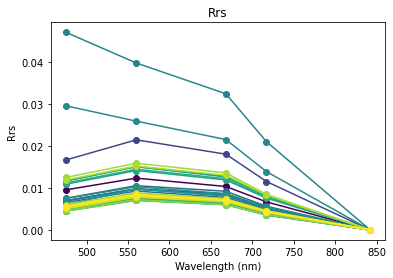

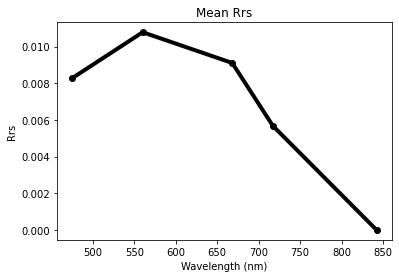

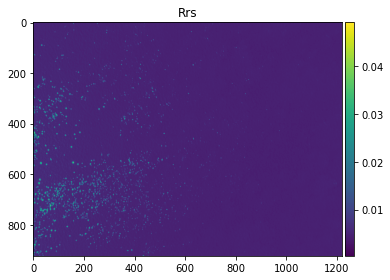

In [111]:
#open all Rrs_stacks tifs and create table of mean Rrs across bands
Rrs_data = []
columns = ['image', 'Rrs_475', 'Rrs_560', 'Rrs_668', 'Rrs_717', 'Rrs_842']
for im in glob.glob(os.path.join(imagePath,'Rrs_blackpixel_stacks')+ "/*.tif"):
    with rasterio.open(im, 'r') as src:
        Rrs = src.read() 
        Rrs = ['capture_'+str(im)]+[np.mean(Rrs[0,:,:])]+[np.mean(Rrs[1,:,:])]+[np.mean(Rrs[2,:,:])]+[np.mean(Rrs[3,:,:])]+[np.mean(Rrs[4,:,:])]
        Rrs_data.append(Rrs)

#save mean Ruas data for each image as .csv
Rrs_data = pd.DataFrame.from_records(Rrs_data, index='image', columns = columns)
Rrs_data.to_csv(os.path.join(imagePath, 'Rrs_blackpixel_data.csv'))
print(Rrs_data.head())

#plot Ruas for every capture
colors = plt.cm.viridis(np.linspace(0,1,len(Ruas_data)))
wv = [475, 560, 668, 717, 842]
for i in range(len(Rrs_data)):
    plt.plot(wv, Rrs_data.iloc[i,0:5],  marker = 'o', color=colors[i])
    plt.title('Rrs')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Rrs') #TODO- add units

#plot mean Ruas across all images 
plt.figure(2)
plt.plot(wv, np.mean(Rrs_data.iloc[:,0:5]),  marker = 'o', color='black', linewidth=4)
plt.title('Mean Rrs')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Rrs') #TODO - add units

#Plot example Ruas .tiff
with rasterio.open(os.path.join(imagePath,'Rrs_blackpixel_stacks','Rrs_11.tif'), 'r') as src:
    Rrs = src.read() 
    fig, axis = plotutils.plotwithcolorbar(Rrs[0,:,:], title='Rrs') #5th image


#### R<sub>rs</sub> method 2: Deglinting approach 

In [112]:
def align_stack_Rrs_deglinting(imgset, overwrite, output_path):
    """
    <explain the functions purpose>

    Parameters
    ----------
    <parameter name> : <parameter format>
        <what is this parameter?>

    Returns
    -------
    <output_name> : <output format>
        <what is this output>
    ------
    """
    
    #create new output directory paths
    Rrs_outputPath = os.path.join(imagePath, output_path)
    
    #create directories if they do not exist
    if not os.path.exists(Rrs_outputPath):
        os.makedirs(Rrs_outputPath)

    #for every flight image, get Lt, Ruas, Ed
    for i in range(len(flight_imgset)):
        Rrs_outputFilename = 'Rrs_' + str(i+1) +'.tif'
        if (not os.path.exists(os.path.join(Rrs_outputPath, Rrs_outputFilename))) or overwrite:
                
                #open Ruas tiffs
                with rasterio.open(os.path.join(imagePath, 'Ruas_stacks', 'Ruas_'+str(i+1)+'.tif')) as Ruas_src:
                    profile = Ruas_src.profile
                    Ruas_all = []
                    for j in range(1,6):
                        Ruas = Ruas_src.read(j)
                        Ruas_all.append(Ruas) #append all Ruas for each band
                    stacked_Ruas = np.stack(Ruas_all) #stack into np.array
                    stacked_Ruas_reshape = stacked_Ruas.reshape(*stacked_Ruas.shape[:-2], -1) #flatten last two dims
                    min_Ruas_NIR = np.percentile(stacked_Ruas_reshape[4,:], .1) #find minimum 10% of Ruas(NIR)
                    
                    #apply linear regression between NIR and visible bands 
                    all_slopes = []
                    for j in range(0,5):
                        slopes = np.polyfit(stacked_Ruas_reshape[4,:], stacked_Ruas_reshape[j,:], 1)[0]
                        all_slopes.append(slopes)
             
                    #calculate Rrs (Ruas - b(Ruas(NIR)-min(Ruas(NIR))))
                    Rrs_all = []
                    for j in range(0,5):
                        Rrs = stacked_Ruas[j,:,:] - all_slopes[j]*(stacked_Ruas[4,:,:]-min_Ruas_NIR)
                        Rrs_all.append(Rrs)
                    stacked_Rrs = np.stack(Rrs_all) #stack into np.array

                    #write new stacked Rrs tif w/ reflectance units
                    with rasterio.open(os.path.join(Rrs_outputPath, Rrs_outputFilename), 'w', **profile) as dst:
                        dst.write(stacked_Rrs)

                capture.clear_image_data()


In [113]:
align_stack_Rrs_deglinting(flight_imgset, overwrite=True, output_path ='Rrs_deglint_stacks')

##### Save mean Rrs data as csv and plot spectra

                                                     Rrs_475   Rrs_560  \
image                                                                    
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.002492  0.006125   
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.005215  0.008764   
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.005247  0.008807   
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.005240  0.008780   
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.005284  0.008808   

                                                     Rrs_668   Rrs_717  \
image                                                                    
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.006962  0.005852   
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.010198  0.008967   
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.010139  0.008897   
capture_F:/Micasense_WQ\10_01_20\0002SET\000_te...  0.010147  0.008857   
capture_F:/Micasense_WQ\10_01_20\0002

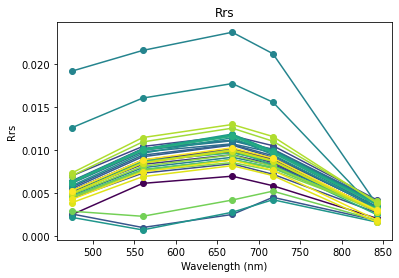

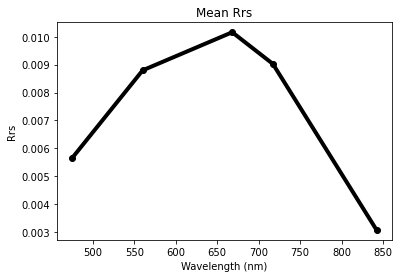

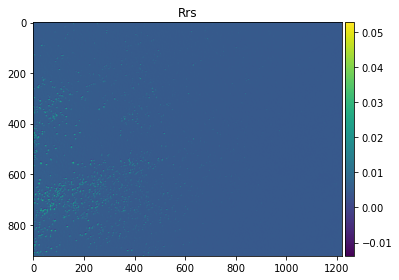

In [114]:
#open all Rrs_stacks tifs and create table of mean Rrs across bands
Rrs_data = []
columns = ['image', 'Rrs_475', 'Rrs_560', 'Rrs_668', 'Rrs_717', 'Rrs_842']
for im in glob.glob(os.path.join(imagePath,'Rrs_deglint_stacks')+ "/*.tif"):
    with rasterio.open(im, 'r') as src:
        Rrs = src.read() 
        Rrs = ['capture_'+str(im)]+[np.mean(Rrs[0,:,:])]+[np.mean(Rrs[1,:,:])]+[np.mean(Rrs[2,:,:])]+[np.mean(Rrs[3,:,:])]+[np.mean(Rrs[4,:,:])]
        Rrs_data.append(Rrs)

#save mean Ruas data for each image as .csv
Rrs_data = pd.DataFrame.from_records(Rrs_data, index='image', columns = columns)
Rrs_data.to_csv(os.path.join(imagePath, 'Rrs_deglint_data.csv'))
print(Rrs_data.head())

#plot Ruas for every capture
colors = plt.cm.viridis(np.linspace(0,1,len(Rrs_data)))
wv = [475, 560, 668, 717, 842]
for i in range(len(Rrs_data)):
    plt.plot(wv, Rrs_data.iloc[i,0:5],  marker = 'o', color=colors[i])
    plt.title('Rrs')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Rrs') #TODO- add units

#plot mean Ruas across all images 
plt.figure(2)
plt.plot(wv, np.mean(Rrs_data.iloc[:,0:5]),  marker = 'o', color='black', linewidth=4)
plt.title('Mean Rrs')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Rrs') #TODO - add units

#Plot example Ruas .tiff
with rasterio.open(os.path.join(imagePath,'Rrs_deglint_stacks','Rrs_11.tif'), 'r') as src:
    Rrs = src.read() 
    fig, axis = plotutils.plotwithcolorbar(Rrs[0,:,:], title='Rrs') #5th image


## Test bed

#### Filter pixels based on Rrs

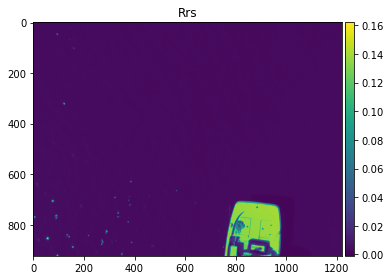

1.4901161e-08
(5, 923, 1219)


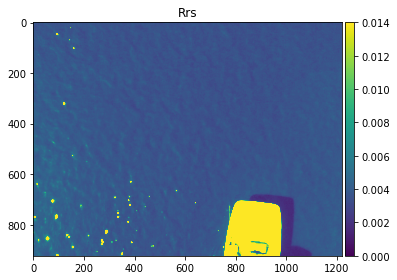

In [44]:
#Plot example Ruas .tiff
with rasterio.open(os.path.join(imagePath,'Rrs_blackpixel_stacks','Rrs_1.tif'), 'r') as src:
    Rrs = src.read() 
fig, axis = plotutils.plotwithcolorbar(Rrs[0,:,:], title='Rrs') #5th image
print(np.nanmax(Rrs[4,:,:]))
 
Rrs[4,:,:][Rrs[4,:,:]>0.01] = np.nan


nan_index = np.isnan(Rrs)
print(nan_index.shape)
for i in range(5):
    Rrs[i,:,:][nan_index[4,:,:]] = np.nan


fig, axis = plotutils.plotwithcolorbar(Rrs[0,:,:], title='Rrs', vmin=0, vmax=.014) #5th image



    

#### Georeference